In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, f1_score
)
from sklearn.base import ClassifierMixin

In [5]:
df = pd.read_csv('../datasets/famcs_students.csv')
df.head()

,cource,group,stream,sex,age,ss,interest,os,weekend_study,bad_sleep,...,social,sport,miss,study_form,foot_size,eye_color,score,retake,hostel,literature
0,4,11,Прикладная информатика,М,20.0,Нет,Математика,MacOS,Да,Да,...,Экстраверт,"Редко, легкая физкультура",3.0,Бюджет,48.0,Карие,9.2,0,"Нет, я из Минска",Да
1,4,11,Прикладная информатика,Ж,20.0,Нет,Программирование,MacOS,Нет,Нет,...,Экстраверт,"Да, я спортсмен",5.0,Бюджет,39.0,Зеленые,8.8,0,"Нет, я из Минска",Да
2,4,11,Прикладная информатика,Ж,19.0,Нет,Программирование,MacOS,Да,Нет,...,Экстраверт,Вообще нет,10.0,Бюджет,41.0,Карие,8.8,0,"Нет, я из Минска",Да
3,4,11,Прикладная информатика,Ж,20.0,Нет,Математика,MacOS,Да,Да,...,Экстраверт,"Да, я спортсмен",3.0,Бюджет,36.0,Карие,8.8,0,"Нет, я из Минска",Да
4,4,11,Прикладная информатика,М,20.0,Нет,Математика,Windows,Да,Нет,...,Интроверт,Вообще нет,1.0,Бюджет,46.0,Зеленые,9.0,0,"Нет, я из Минска",Да


In [6]:
binary_cols = ['ss', 'interest', 'weekend_study', 'bad_sleep', 'glasses', 'anime', 'study_form', 'literature']
N = 6
target_col = binary_cols[N % 8]
min_features = 5

np.random.seed(42)

In [7]:
print("shape:", df.shape)
print("Столбцы:")
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col}")
print("целевая колонка:", target_col)

shape: (127, 25)
Столбцы:
 1. cource
 2. group
 3. stream
 4. sex
 5. age
 6. ss
 7. interest
 8. os
 9. weekend_study
10. bad_sleep
11. glasses
12. work_experience
13. ai
14. height
15. anime
16. social
17. sport
18. miss
19. study_form
20. foot_size
21. eye_color
22. score
23. retake
24. hostel
25. literature
целевая колонка: study_form


In [8]:
# блок 3: предобработка (кодирование целевой, кодирование категориальных, заполнение пропусков)
# 1) кодируем целевую переменную (labelencoder) — чтобы y был 0/1
le_target = LabelEncoder()
if df[target_col].dtype == 'object' or not np.issubdtype(df[target_col].dtype, np.number):
    df[target_col] = le_target.fit_transform(df[target_col].astype(str))
else:
    df[target_col] = pd.to_numeric(df[target_col], errors='coerce').fillna(0).astype(int)

# 2) признаки: убираем целевую из признаков
x_raw = df.drop(columns=[target_col]).copy()
y = df[target_col].values

# 3) кодируем категориальные признаки: one-hot для строковых столбцов
cat_cols = x_raw.select_dtypes(include=['object', 'category']).columns.tolist()
if len(cat_cols) > 0:
    x_encoded = pd.get_dummies(x_raw, columns=cat_cols, drop_first=True)
else:
    x_encoded = x_raw.copy()

# 4) приводим оставшиеся к числовым и заполняем пропуски медианой
for c in x_encoded.columns:
    x_encoded[c] = pd.to_numeric(x_encoded[c], errors='coerce')
x_encoded = x_encoded.fillna(x_encoded.median())

print("после кодирования shape x:", x_encoded.shape)


после кодирования shape x: (127, 45)


In [9]:
# блок 4: отбор признаков (по дисперсии) и масштабирование
# берем top-k по дисперсии (простой и прозрачный критерий), но не менее min_features
variances = x_encoded.var().sort_values(ascending=False)
k = max(min_features, min(12, len(variances)))  # можно регулировать
selected_features = variances.index.tolist()[:k]
print("выбранные признаки:")
for i, col in enumerate(selected_features, 1):
    print(f"{i:2d}. {col}")

x = x_encoded[selected_features].copy()

# масштабируем (z-score) - важно для k-nn и логистики
scaler = StandardScaler()
x_values = scaler.fit_transform(x)
# сохраним pandas-версию для удобства
x = pd.DataFrame(x_values, columns=selected_features)


выбранные признаки:
 1. height
 2. miss
 3. group
 4. foot_size
 5. score
 6. age
 7. sport_Редко, легкая физкультура
 8. hostel_Нет, я из Минска
 9. glasses_Нет
10. social_Экстраверт
11. anime_Нет
12. os_Windows


In [10]:
# блок 5: разбиение на train/val/test 
x_train, x_temp, y_train, y_temp = train_test_split(
    x, y, test_size=0.30, random_state=42, stratify=y
)
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("sizes: train", x_train.shape, "val", x_val.shape, "test", x_test.shape)
print("распределение классов (train):", Counter(y_train))


sizes: train (88, 12) val (19, 12) test (20, 12)
распределение классов (train): Counter({np.int64(0): 65, np.int64(1): 23})


In [16]:
class trivial_classifier(ClassifierMixin):
    def fit(self, y):
        y = np.asarray(y)
        self.most = int(Counter(y).most_common(1)[0][0])
        self.prior = np.mean(y)
        return self

    def predict(self, x):
        return np.full(len(x), self.most, dtype=int)

    def predict_proba(self, x):
        return np.full(len(x), self.prior, dtype=float)

In [17]:
import numpy as np
from sklearn.base import ClassifierMixin


class gaussian_nb_manual(ClassifierMixin):
    def fit(self, x, y):
        x = np.asarray(x)
        y = np.asarray(y)

        self.classes = np.unique(y)
        self.params = {}
        self.priors = {}

        for c in self.classes:
            xc = x[y == c]
            self.params[c] = {
                "mean": xc.mean(axis=0),
                "var": xc.var(axis=0) + 1e-8
            }
            self.priors[c] = len(xc) / len(x)

        return self

    def _log_likelihood(self, x_row, mean, var):
        return -0.5 * np.sum(
            np.log(2 * np.pi * var) + (x_row - mean) ** 2 / var
        )

    def predict_proba(self, x):
        x = np.asarray(x)
        probs = []

        for xr in x:
            logps = []
            for c in self.classes:
                lp = np.log(self.priors[c]) + self._log_likelihood(
                    xr, self.params[c]["mean"], self.params[c]["var"]
                )
                logps.append(lp)

            # softmax
            maxlp = np.max(logps)
            exps = np.exp(logps - maxlp)
            posts = exps / exps.sum()

            # вероятность класса 1
            if 1 in self.classes:
                probs.append(posts[list(self.classes).index(1)])
            else:
                probs.append(0.0)

        return np.array(probs)

    def predict(self, x, thr=0.5):
        return (self.predict_proba(x) >= thr).astype(int)


In [18]:
import numpy as np
from sklearn.base import ClassifierMixin


class knn_manual(ClassifierMixin):
    def __init__(self, k=5):
        self.k = k

    def fit(self, x, y):
        self.x = np.asarray(x)
        self.y = np.asarray(y)
        return self

    def predict_proba(self, xq):
        xq = np.asarray(xq)
        probs = []

        for q in xq:
            d = np.sqrt(np.sum((self.x - q) ** 2, axis=1))
            idx = np.argsort(d)[:self.k]
            probs.append(np.mean(self.y[idx]))

        return np.array(probs)

    def predict(self, xq):
        return (self.predict_proba(xq) >= 0.5).astype(int)


In [20]:
import numpy as np
from sklearn.base import ClassifierMixin


class logistic_manual(ClassifierMixin):
    def __init__(self, lr=0.1, max_iter=10000, tol=1e-6, c=1.0):
        self.lr = lr
        self.max_iter = max_iter
        self.tol = tol
        self.c = c

    def fit(self, x, y):
        x = np.asarray(x)
        y = np.asarray(y)

        n, m = x.shape
        xb = np.hstack([np.ones((n, 1)), x])
        self.w = np.zeros(m + 1)

        for i in range(self.max_iter):
            z = xb.dot(self.w)
            p = 1 / (1 + np.exp(-np.clip(z, -30, 30)))
            grad = xb.T.dot(p - y) / n

            grad[1:] += (1 / self.c) * self.w[1:] / n

            w_new = self.w - self.lr * grad

            if np.linalg.norm(w_new - self.w) < self.tol:
                self.w = w_new
                break

            self.w = w_new

        return self

    def predict_proba(self, x):
        x = np.asarray(x)
        xb = np.hstack([np.ones((x.shape[0], 1)), x])
        z = xb.dot(self.w)
        return 1 / (1 + np.exp(-np.clip(z, -30, 30)))

    def predict(self, x, thr=0.5):
        return (self.predict_proba(x) >= thr).astype(int)


выбранный k: 1 f1: 0.5
лучший порог для логистики: 0.48000000000000004 f1: 0.75


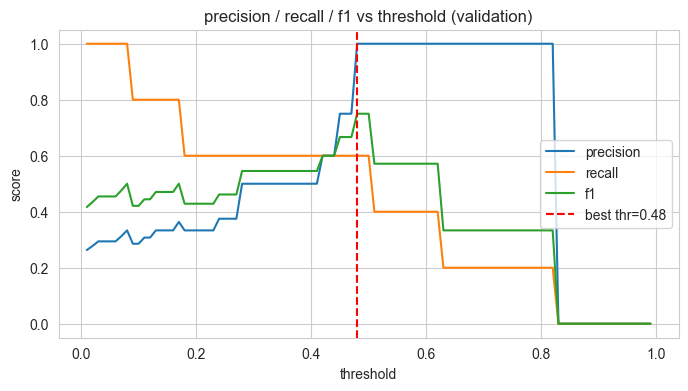

In [22]:
# блок 7: подбор k для knn
cand_k = list(range(1, 20, 2))
best_k = cand_k[0]
best_f1 = -1
for k in cand_k:
    model_k = knn_manual(k=k).fit(x_train, y_train)
    pred_val = model_k.predict(x_val)
    f1 = f1_score(y_val, pred_val, zero_division=0)
    if f1 > best_f1:
        best_f1 = f1
        best_k = k
print("выбранный k:", best_k, "f1:", best_f1)

# подбор порога для логистики
log = logistic_manual(lr=0.5, max_iter=20000, c=1.0).fit(x_train, y_train)
probs_val = log.predict_proba(x_val)
thresholds = np.linspace(0.01, 0.99, 99)
best_thr = thresholds[0]
best_f1_thr = -1
precisions = []
recalls = []
f1s = []
for t in thresholds:
    p = (probs_val >= t).astype(int)
    precisions.append(precision_score(y_val, p, zero_division=0))
    recalls.append(recall_score(y_val, p, zero_division=0))
    f1s.append(f1_score(y_val, p, zero_division=0))
    if f1s[-1] > best_f1_thr:
        best_f1_thr = f1s[-1]
        best_thr = t

print("лучший порог для логистики:", best_thr, "f1:", best_f1_thr)
# график precision/recall vs threshold
plt.figure(figsize=(8,4))
plt.plot(thresholds, precisions, label='precision')
plt.plot(thresholds, recalls, label='recall')
plt.plot(thresholds, f1s, label='f1')
plt.axvline(best_thr, color='red', linestyle='--', label=f'best thr={best_thr:.2f}')
plt.xlabel('threshold')
plt.ylabel('score')
plt.title('precision / recall / f1 vs threshold (validation)')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
# блок 8: обучение финальных моделей и оценка на тесте
results = []

# trivial
triv = trivial_classifier().fit(y_train)
y_pred_triv = triv.predict(x_test)
y_prob_triv = triv.predict_proba(x_test)
results.append(('trivial', y_test, y_pred_triv, y_prob_triv))

# gaussian nb
gnb = gaussian_nb_manual().fit(x_train, y_train)
y_prob_gnb = gnb.predict_proba(x_test)
y_pred_gnb = gnb.predict(x_test)
results.append(('gaussian_nb', y_test, y_pred_gnb, y_prob_gnb))

# knn with best_k
knn_model = knn_manual(k=best_k).fit(x_train, y_train)
y_prob_knn = knn_model.predict_proba(x_test)
y_pred_knn = knn_model.predict(x_test)
results.append((f'knn_k{best_k}', y_test, y_pred_knn, y_prob_knn))

# logistic with best threshold
y_prob_log = log.predict_proba(x_test)
y_pred_log = (y_prob_log >= best_thr).astype(int)
results.append((f'logistic_thr{best_thr:.2f}', y_test, y_pred_log, y_prob_log))

# печать метрик и матриц ошибок
summary = []
for name, y_t, y_p, y_score in results:
    acc = accuracy_score(y_t, y_p)
    prec = precision_score(y_t, y_p, zero_division=0)
    rec = recall_score(y_t, y_p, zero_division=0)
    try:
        roc = roc_auc_score(y_t, y_score) if (y_score is not None) else float('nan')
    except:
        roc = float('nan')
    cm = confusion_matrix(y_t, y_p)
    print("\n модель:", name)
    print("accuracy:", round(acc,4), "precision:", round(prec,4), "recall:", round(rec,4), "roc-auc:", round(roc,4) if not np.isnan(roc) else 'n/a')
    print("confusion matrix:\n", cm)
    summary.append({'model': name, 'accuracy': acc, 'precision': prec, 'recall': rec, 'roc_auc': roc})

# сводная таблица
summary_df = pd.DataFrame(summary)
display(summary_df.round(4))



 модель: trivial
accuracy: 0.75 precision: 0.0 recall: 0.0 roc-auc: 0.5
confusion matrix:
 [[15  0]
 [ 5  0]]

 модель: gaussian_nb
accuracy: 0.8 precision: 1.0 recall: 0.2 roc-auc: 0.5867
confusion matrix:
 [[15  0]
 [ 4  1]]

 модель: knn_k1
accuracy: 0.65 precision: 0.25 recall: 0.2 roc-auc: 0.5
confusion matrix:
 [[12  3]
 [ 4  1]]

 модель: logistic_thr0.48
accuracy: 0.75 precision: 0.5 recall: 0.2 roc-auc: 0.44
confusion matrix:
 [[14  1]
 [ 4  1]]


,model,accuracy,precision,recall,roc_auc
0,trivial,0.75,0.00,0.0,0.5000
1,gaussian_nb,0.80,1.00,0.2,0.5867
2,knn_k1,0.65,0.25,0.2,0.5000
3,logistic_thr0.48,0.75,0.50,0.2,0.4400


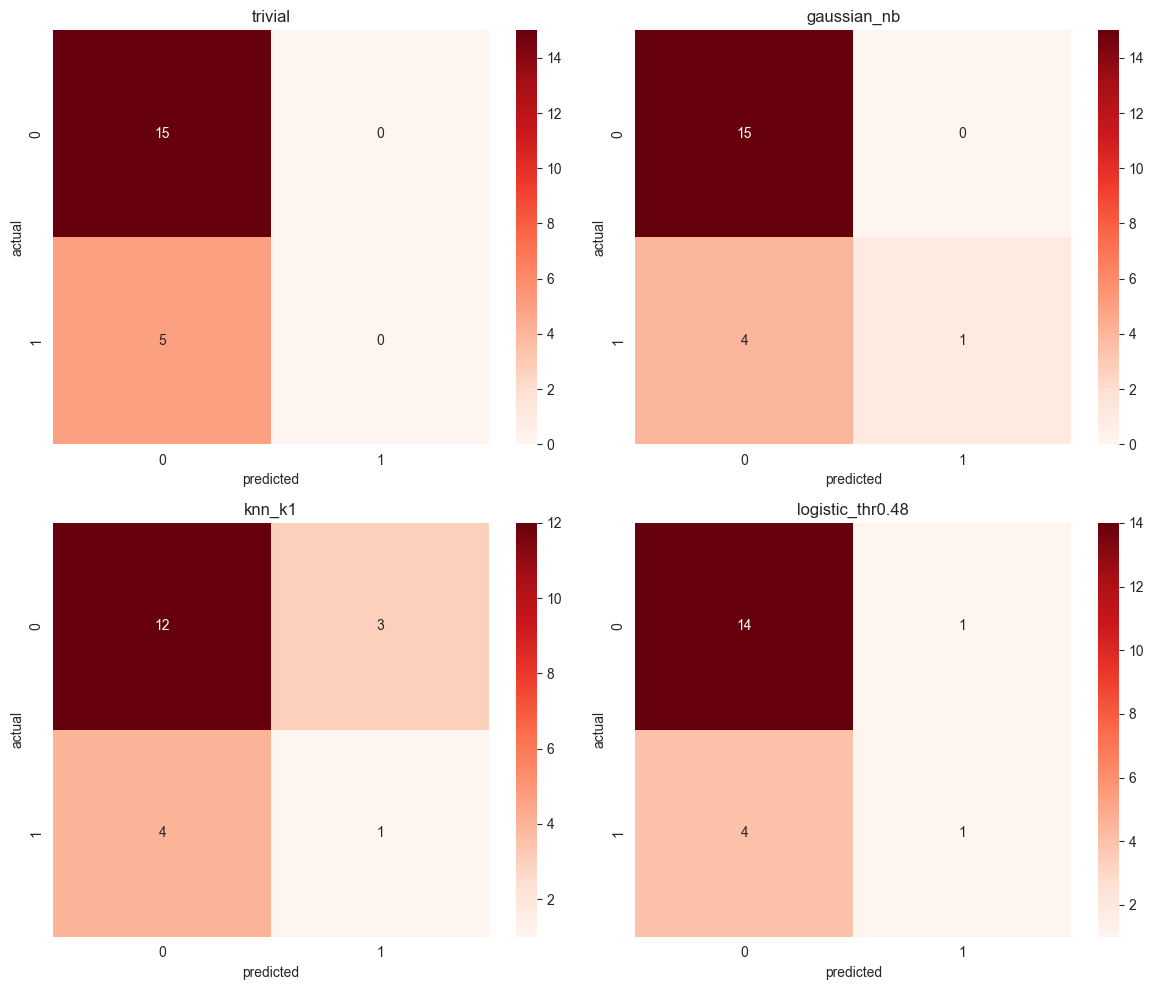

In [24]:
# блок 9: графическое отображение матриц ошибок
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for ax, (name, y_t, y_p, y_score) in zip(axes.flatten(), results):
    cm = confusion_matrix(y_t, y_p)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', ax=ax)
    ax.set_title(name)
    ax.set_xlabel('predicted')
    ax.set_ylabel('actual')
plt.tight_layout()
plt.show()


АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ (Логистическая регрессия)
                            Feature    Weight  Abs_Weight
7           hostel_Нет, я из Минска  0.617165    0.617165
2                             group  0.607374    0.607374
11                       os_Windows -0.592189    0.592189
3                         foot_size -0.507254    0.507254
9                 social_Экстраверт -0.479905    0.479905
0                            height  0.344772    0.344772
8                       glasses_Нет -0.227715    0.227715
4                             score -0.219664    0.219664
5                               age  0.160454    0.160454
10                        anime_Нет -0.144394    0.144394
6   sport_Редко, легкая физкультура -0.087695    0.087695
1                              miss  0.021170    0.021170


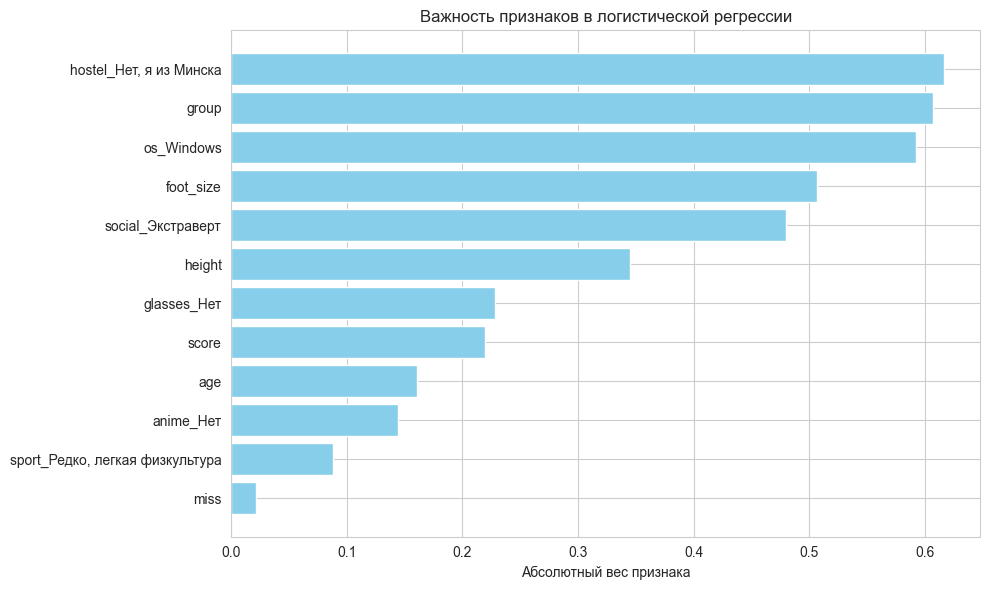

In [25]:
# # Анализ важности признаков для логистической регрессии
#
# print("АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ (Логистическая регрессия)")
#
# # Получаем веса модели (без bias)
# weights = log.w[1:]  # w[0] — смещение (bias), остальные — признаки
# feature_importance = pd.DataFrame({
#     'Feature': selected_features,
#     'Weight': weights
# })
# feature_importance['Abs_Weight'] = np.abs(feature_importance['Weight'])
# feature_importance = feature_importance.sort_values('Abs_Weight', ascending=False)
#
# # Печать таблицы
# print(feature_importance)
#
# # Визуализация важности признаков
# plt.figure(figsize=(10, 6))
# plt.barh(feature_importance['Feature'], feature_importance['Abs_Weight'], color='skyblue')
# plt.xlabel('Абсолютный вес признака')
# plt.title('Важность признаков в логистической регрессии')
# plt.gca().invert_yaxis()  # самый важный сверху
# plt.tight_layout()
# plt.show()
